In [19]:
from PIL import Image
import numpy as np

# Change this path to the location of your mask file
mask_path = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\OASIS\keras_png_slices_seg_test\seg_441_slice_0.nii.png"

try:
    # Open the image without converting it to a specific mode
    mask = Image.open(mask_path)
    
    # Check the image mode
    print(f"Image mode: {mask.mode}")
    
    # Convert the image to a NumPy array to inspect pixel values
    mask_np = np.array(mask)
    
    # Find and print the unique pixel values
    unique_pixels = np.unique(mask_np)
    print(f"Unique pixel values: {unique_pixels}")
    
except FileNotFoundError:
    print(f"Error: The file was not found at {mask_path}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Image mode: L
Unique pixel values: [  0  85 170 255]


In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
# --- 1. 数据集定义和加载 ---
class MRISegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        # 1. Use PIL to open images, but do NOT convert the mask to 'L' mode yet
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path)
        
        # 2. Resize both images and masks.
        resize_transform = transforms.Resize((64, 64), interpolation=Image.NEAREST)
        image = resize_transform(image)
        mask = resize_transform(mask)

        # 3. Convert image to a tensor and normalize
        image_tensor = transforms.ToTensor()(image)

        # 4. Convert the mask to a NumPy array to work with raw pixel values
        mask_np = np.array(mask)

        # 5. Map pixel values from [0, 85, 170, 255] to [0, 1, 2, 3]
        # This mapping is crucial and should be done on the raw numpy array
        mapped_mask_np = np.zeros_like(mask_np)
        mapped_mask_np[mask_np == 0] = 0
        mapped_mask_np[mask_np == 85] = 1
        mapped_mask_np[mask_np == 170] = 2
        mapped_mask_np[mask_np == 255] = 3
        
        # 6. Convert the mapped NumPy array back to a PyTorch tensor
        mask_tensor = torch.from_numpy(mapped_mask_np).long()

        # 7. Perform one-hot encoding
        num_classes = 4
        mask_one_hot = F.one_hot(mask_tensor, num_classes=num_classes).permute(2, 0, 1).float()
        
        return image_tensor, mask_one_hot

In [22]:
# --- 2. VAE-U-Net 模型定义 ---
class VAE_UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4, latent_dim=128): # out_channels 改为 4
        super(VAE_UNet, self).__init__()
        self.latent_dim = latent_dim
        
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, 1, 1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, 1, 1),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc_conv1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc_conv2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc_conv3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(256, 512)
        
        # VAE latent space layers
        self.flatten_size = 512 * (64 // 8) * (64 // 8)
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        
        # Decoder - upsampling path with skip connections
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec_conv1 = conv_block(256 + 256, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec_conv2 = conv_block(128 + 128, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec_conv3 = conv_block(64 + 64, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, 1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        e1 = self.enc_conv1(x)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)
        
        h = self.bottleneck(p3)
        h_flat = h.view(h.size(0), -1)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        z = self.reparameterize(mu, logvar)

        d1 = self.upconv1(h)
        d1 = torch.cat([d1, e3], dim=1)
        d1 = self.dec_conv1(d1)
        
        d2 = self.upconv2(d1)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec_conv2(d2)
        
        d3 = self.upconv3(d2)
        d3 = torch.cat([d3, e1], dim=1)
        d3 = self.dec_conv3(d3)
        
        output = self.final_conv(d3)
        return output, mu, logvar


In [23]:
# --- 3. 损失函数和评估指标 ---
def get_class_weights(dataloader):
    # 类别数改为 4
    class_counts = torch.zeros(4)
    total_pixels = 0
    
    
    # 在 get_class_weights 函数的 for 循环之后
    # 避免除以零错误
    class_counts[class_counts == 0] = 1e-6
    # 调整权重计算公式以适应新的类别数量
    weights = total_pixels / (class_counts * 4)
    weights /= weights.sum()
    
    return weights

def dice_loss(y_pred, y_true, class_weights, smooth=1e-6):
    y_pred = F.softmax(y_pred, dim=1)
    
    intersection = torch.sum(y_pred * y_true, dim=(2, 3))
    union = torch.sum(y_pred, dim=(2, 3)) + torch.sum(y_true, dim=(2, 3))
    
    dice_per_class = (2. * intersection + smooth) / (union + smooth)
    
    weighted_dice = class_weights.to(device) * dice_per_class
    
    return (1 - weighted_dice).mean()

def total_loss(y_pred, y_true, mu, logvar, class_weights, dice_weight=1.0, kld_weight=1e-4):
    dice_l = dice_loss(y_pred, y_true, class_weights)
    kld_l = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return dice_weight * dice_l + kld_weight * kld_l, dice_l, kld_l

def dice_coefficient(y_pred, y_true, smooth=1e-6):
    y_pred_class = torch.argmax(y_pred, dim=1)
    y_true_class = torch.argmax(y_true, dim=1)
    
    # 类别数改为 4
    num_classes = 4
    dice_scores = []
    for cls in range(num_classes):
        pred_mask = (y_pred_class == cls).float()
        true_mask = (y_true_class == cls).float()
        
        intersection = torch.sum(pred_mask * true_mask)
        union = torch.sum(pred_mask) + torch.sum(true_mask)
        
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())
        
    return dice_scores

In [24]:
# --- 4. 训练和验证 ---
def train_model(model, train_loader, val_loader, epochs=50, learning_rate=1e-4, class_weights=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    kld_weight = 1e-4
    
    for epoch in range(epochs):
        model.train()
        train_total_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs, mu, logvar = model(images)
            loss, _, _ = total_loss(outputs, masks, mu, logvar, class_weights, kld_weight=kld_weight)
            loss.backward()
            optimizer.step()
            train_total_loss += loss.item()

        avg_train_loss = train_total_loss / len(train_loader)

        model.eval()
        val_dice_scores_all = []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs, _, _ = model(images)
                dice_scores = dice_coefficient(outputs, masks)
                val_dice_scores_all.append(dice_scores)

        avg_val_dices = np.mean(val_dice_scores_all, axis=0)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss={avg_train_loss:.4f}, "
              f"Val DSC_BG={avg_val_dices[0]:.4f}, "
              f"Val DSC_DeepGray={avg_val_dices[1]:.4f}, "
              f"Val DSC_LightGray={avg_val_dices[2]:.4f}, "
              f"Val DSC_White={avg_val_dices[3]:.4f}")
        
        # 检查是否满足停止条件
        # Check if all four DSC scores are >= 0.90
        if all(score >= 0.90 for score in avg_val_dices):
            print("DSC > 90%. Save the model and stop the training.")
            torch.save(model.state_dict(), 'vae_unet_segmentation_model.pth')
            break  # 停止训练循环

    torch.save(model.state_dict(), 'vae_unet_segmentation_model_1.pth')

In [25]:
def evaluate_and_visualize(model, test_loader, num_samples=5, save_path="segmentation_results.png"):
    """
    评估模型在测试集上的性能并可视化结果。

    参数:
        model (torch.nn.Module): 训练好的模型。
        test_loader (torch.utils.data.DataLoader): 测试数据集的 DataLoader。
        num_samples (int): 要可视化的样本数量。
        save_path (str): 保存结果图的文件路径。
    """
    model.eval()
    test_dice_scores_all = []
    
    images_to_show = []
    true_masks_to_show = []
    pred_masks_to_show = []
    
    with torch.no_grad():
        for i, (images, true_masks) in enumerate(test_loader):
            if i >= num_samples:
                break
            
            images = images.to(device)
            true_masks = true_masks.to(device)
            
            # 这里假设模型的输出格式为 outputs, _, _
            outputs, _, _ = model(images)
            
            dice_scores = dice_coefficient(outputs, true_masks)
            test_dice_scores_all.append(dice_scores)
            
            # 将数据从 GPU 移到 CPU 并转换为 NumPy 数组
            images_to_show.append(images.squeeze().cpu().numpy())
            true_masks_to_show.append(torch.argmax(true_masks.squeeze(), dim=0).cpu().numpy())
            pred_masks_to_show.append(torch.argmax(outputs.squeeze(), dim=0).cpu().numpy())

    avg_test_dices = np.mean(test_dice_scores_all, axis=0)
    print("\nTesting: ")
    print(f"Avg DSC_BG = {avg_test_dices[0]:.4f}")
    print(f"Avg DSC_DeepGray = {avg_test_dices[1]:.4f}")
    print(f"Avg DSC_LightGray = {avg_test_dices[2]:.4f}")
    print(f"Avg DSC_White = {avg_test_dices[3]:.4f}")

    # 创建子图，用于显示原始图像、真实掩码和预测掩码
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    for i in range(num_samples):
        # 原始图像
        axes[i, 0].imshow(images_to_show[i], cmap='gray')
        axes[i, 0].set_title("Original image")
        axes[i, 0].axis('off')
        
        # 真实掩码
        axes[i, 1].imshow(true_masks_to_show[i], cmap='jet')
        axes[i, 1].set_title("True mask")
        axes[i, 1].axis('off')
        
        # 预测掩码
        axes[i, 2].imshow(pred_masks_to_show[i], cmap='jet')
        axes[i, 2].set_title("Pred mask")
        axes[i, 2].axis('off')

    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
    
    # 保存图像到文件
    plt.savefig(save_path, dpi=300)
    print(f"\nSave to {save_path}")

    # plt.show() # 如果不需要在屏幕上显示，可以注释掉这一行

Training set: 9664
Testinf set: 1120
Validation set: 544

Testing: 
Avg DSC_BG = 0.9974
Avg DSC_DeepGray = 0.9336
Avg DSC_LightGray = 0.9029
Avg DSC_White = 0.9437

Save to segmentation_results.png


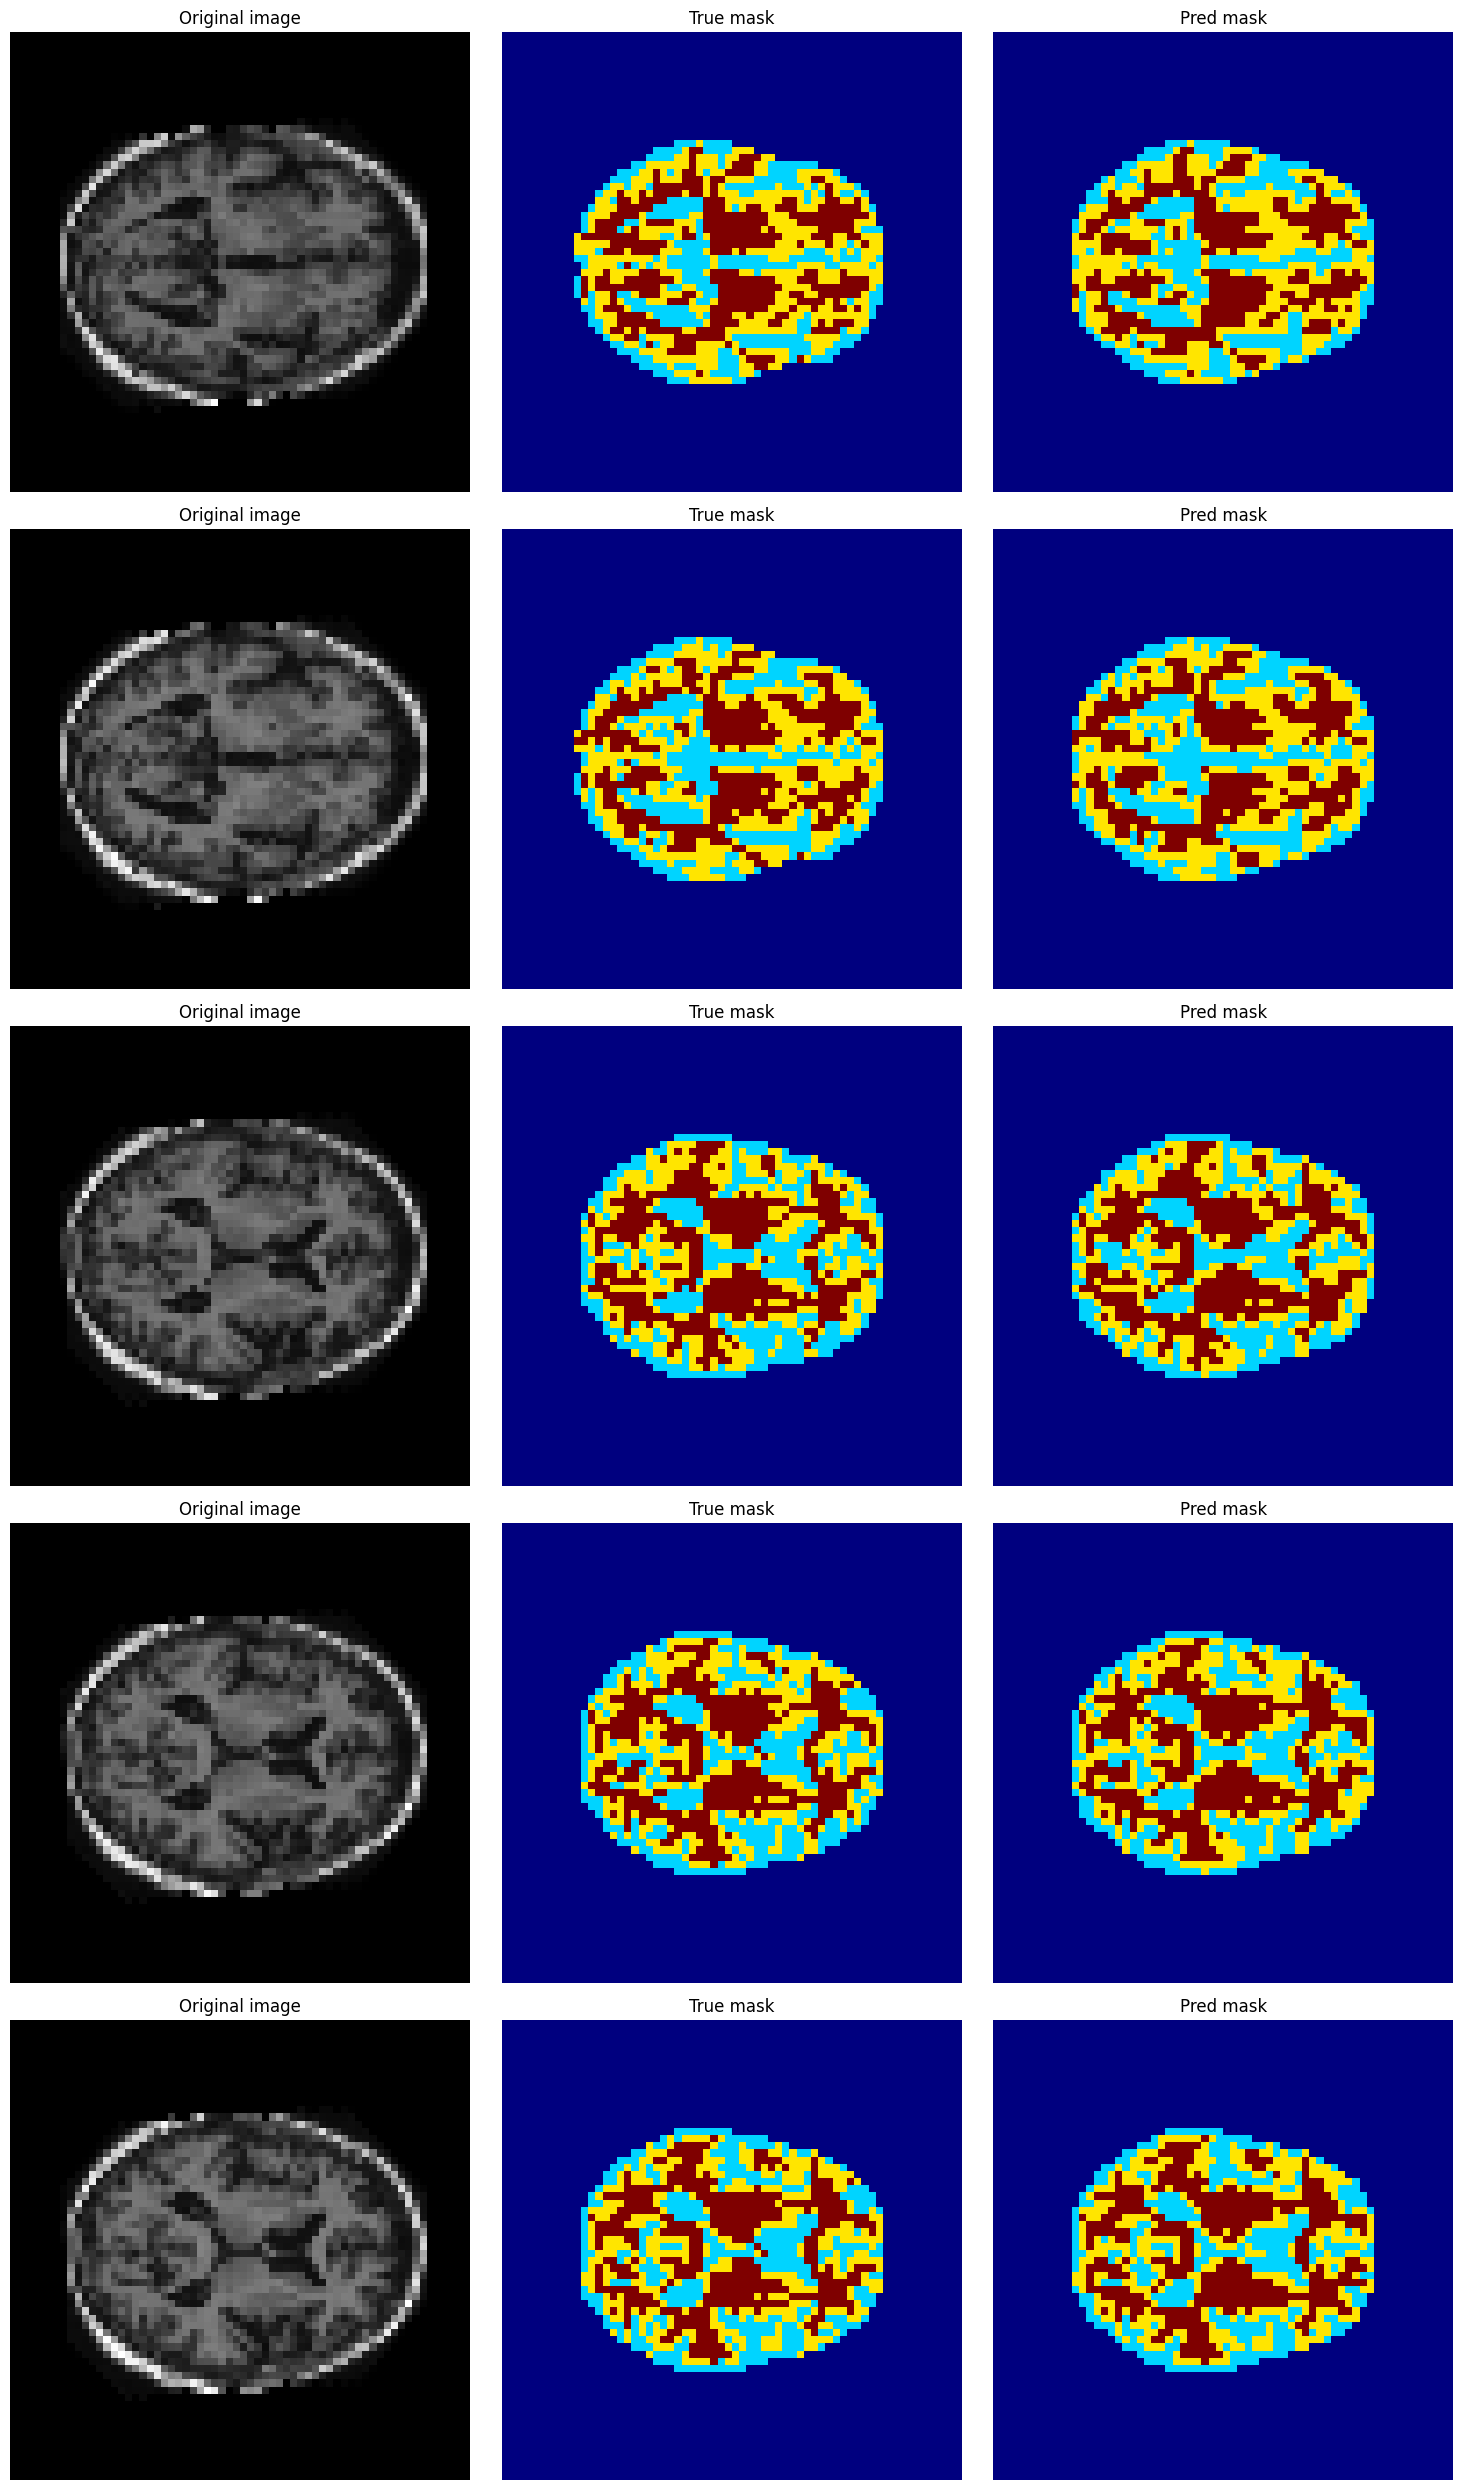

In [26]:
# --- 主程序入口 ---
if __name__ == "__main__":
    # 数据目录
    train_image_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_train"
    train_mask_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_seg_train"
    val_image_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_validate"
    val_mask_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_seg_validate"
    test_image_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_test"
    test_mask_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_seg_test"

    # 数据加载器
    train_dataset = MRISegmentationDataset(train_image_dir, train_mask_dir)
    val_dataset = MRISegmentationDataset(val_image_dir, val_mask_dir)
    test_dataset = MRISegmentationDataset(test_image_dir, test_mask_dir)

    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    print(f"Training set: {len(train_dataset)}")
    print(f"Testinf set: {len(val_dataset)}")
    print(f"Validation set: {len(test_dataset)}")

    class_weights = get_class_weights(train_loader)
    
    model = VAE_UNet().to(device)
    
    # 加载模型
    model.load_state_dict(torch.load('vae_unet_segmentation_model.pth'))
    model.eval() # 切换到评估模式
    
    evaluate_and_visualize(model, test_loader, num_samples=5)

In [ ]:
# --- 主程序入口 ---
if __name__ == "__main__":
    # 数据目录
    train_image_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_train"
    train_mask_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_seg_train"
    val_image_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_validate"
    val_mask_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_seg_validate"
    test_image_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_test"
    test_mask_dir = r"D:\2025大四上s2UQ\COMP3710\Pattern Recognition\keras_png_slices_data\keras_png_slices_seg_test"

    # 数据加载器
    train_dataset = MRISegmentationDataset(train_image_dir, train_mask_dir)
    val_dataset = MRISegmentationDataset(val_image_dir, val_mask_dir)
    test_dataset = MRISegmentationDataset(test_image_dir, test_mask_dir)

    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    print(f"Training set: {len(train_dataset)}")
    print(f"Testinf set: {len(val_dataset)}")
    print(f"Validation set: {len(test_dataset)}")

    class_weights = get_class_weights(train_loader)
    
    model = VAE_UNet().to(device)
    
    train_model(model, train_loader, val_loader, epochs=150, learning_rate=1e-4, class_weights=class_weights)
    
    evaluate_and_visualize(model, test_loader, num_samples=5)